In [139]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import time
from datasets import load_dataset
from PIL import Image
from torchvision import transforms
from typing import Dict, Tuple
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [140]:
df = pd.read_csv("/kaggle/input/vqa-filtered/textpreprocessed_labelencoding.csv")
df

,image_id,question_id,question_preprocessed,question_type,answer_preprocessed,answers,answer_type,answer_encoded
0,/kaggle/input/visual-question-answering/train2...,262146000,what color is the snow,what color is the,white,"['white', 'white', 'white', 'white', 'white', ...",other,959
1,/kaggle/input/visual-question-answering/train2...,262146001,what is the person doing,what is the person,skiing,"['skiing', 'skiing', 'skiing', 'skiing', 'skii...",other,791
2,/kaggle/input/visual-question-answering/train2...,262146002,what color is the persons headwear,what color is the,red,"['red', 'red', 'red & white', 'black', 'red', ...",other,708
3,/kaggle/input/visual-question-answering/train2...,393221000,is the sky blue,is the,yes,"['yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'ye...",yes/no,995
4,/kaggle/input/visual-question-answering/train2...,393221001,is there snow on the mountains,is there,yes,"['yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'ye...",yes/no,995
...,...,...,...,...,...,...,...,...
96886,/kaggle/input/visual-question-answering/train2...,393195000,why is she smiling,why,happy,"['heard joke', 'happy', ""she's enjoying her bo...",other,419
96887,/kaggle/input/visual-question-answering/train2...,393195001,is the woman wearing a hat,is the woman,yes,"['yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'ye...",yes/no,995
96888,/kaggle/input/visual-question-answering/train2...,393195002,is the woman wearing glasses,is the woman,yes,"['yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'ye...",yes/no,995
96889,/kaggle/input/visual-question-answering/train2...,262136000,can he be sharpening blades,none of the above,yes,"['yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'ye...",yes/no,995


In [141]:
answer_encoding_mapping = dict(zip(df['answer_encoded'], df['answer_preprocessed']))

In [142]:
import torch.nn as nn
from transformers import BertModel, ViTModel

class VQAModel(nn.Module):
    def __init__(self, bert_model_name='google-bert/bert-base-uncased', vit_model_name='google/vit-base-patch16-224', num_labels=1000, intermediate_dim=128):
        super(VQAModel, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.vit = ViTModel.from_pretrained(vit_model_name)
        self.fusion = nn.Sequential(
            nn.Linear(self.bert.config.hidden_size + self.vit.config.hidden_size, intermediate_dim),
            nn.ReLU(),
            nn.Dropout(0.5),
        )
        
        self.classifier = nn.Linear(intermediate_dim, num_labels)
        # self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask, pixel_values, labels=None):
        # Get BERT and ViT outputs
        bert_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        vit_outputs = self.vit(pixel_values=pixel_values)
        
        fused_output = self.fusion(
            torch.cat(
                [
                    bert_outputs.pooler_output,
                    vit_outputs.pooler_output,
                ],
                dim=1
            )
        )
        
        logits = self.classifier(fused_output)
        
        # Element-wise dot product of BERT and ViT embeddings
#         combined = bert_outputs.last_hidden_state[:, 0, :] * vit_outputs.pooler_output
        
        # Classification
#         logits = self.classifier(combined)
        
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits, labels)
            return loss, logits
        else:
            return logits


In [143]:
import torch
from transformers import BertTokenizer, AutoImageProcessor
from safetensors import safe_open

# Initialize the model with the configuration
model = VQAModel()
model.to(device)

safetensors_path = '/kaggle/input/base-model-vr-project/model.safetensors'
with safe_open(safetensors_path, framework="pt", device=device) as f:
    state_dict = {key: f.get_tensor(key) for key in f.keys()}
model.load_state_dict(state_dict)

# Load the tokenizer and image processor
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
image_processor = AutoImageProcessor.from_pretrained('google/vit-base-patch16-224')


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [144]:
model.eval()

VQAModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=T

In [145]:
def preprocess_function(sample):
    # Tokenize the question
    inputs = bert_tokenizer(sample['question_preprocessed'], padding='max_length', truncation=True, return_tensors='pt')
    
    # Load and preprocess image
    image = Image.open(sample['image_id']).convert("RGB")
    pixel_values = image_processor(images=image, return_tensors='pt')['pixel_values']
    
    inputs['pixel_values'] = pixel_values
    inputs['image'] = sample['image_id']
    return inputs

In [146]:
# Sample data for inference
sample_data = df[['image_id', 'question_preprocessed']].sample(n=1).iloc[0].to_dict()
print(sample_data)

# Preprocess the sample data
preprocessed_sample = preprocess_function(sample_data)


{'image_id': '/kaggle/input/visual-question-answering/train2014/train2014/COCO_train2014_000000525128.jpg', 'question_preprocessed': 'is the grass thick'}


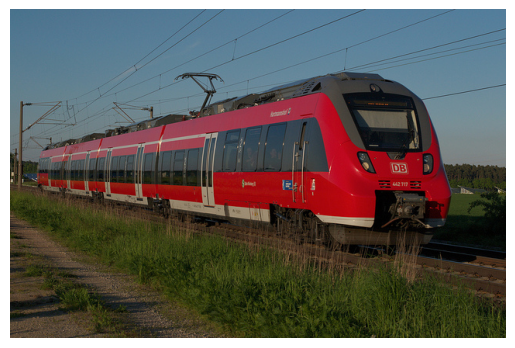

Question: is the grass thick
Predicted Answer: yes


In [147]:
import matplotlib.pyplot as plt

with torch.no_grad():
    input_ids = preprocessed_sample['input_ids'].to(device)
    attention_mask = preprocessed_sample['attention_mask'].to(device)
    pixel_values = preprocessed_sample['pixel_values'].to(device)
    
    logits = model(input_ids=input_ids, attention_mask=attention_mask, pixel_values=pixel_values)
    
    # Assuming you have a way to decode logits to answers
    predicted_answer = logits.argmax(dim=-1).item() 
    predicted_answer = answer_encoding_mapping.get(predicted_answer, "Unknown")
    
    image = Image.open(preprocessed_sample['image'])
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    
    print(f"Question: {sample_data['question_preprocessed']}")
    print(f"Predicted Answer: {predicted_answer}")